## Домашнее задание №1

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

**ДЗ выполнил:** Тихонов Сергей ИАД-4

In [1]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
from tqdm import tqdm_notebook
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output

device = 'cuda'
import warnings
warnings.filterwarnings('ignore')

### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [2]:
x = torch.normal(0, 1, [3, 5]) 
y = torch.normal(0, 1, [5, 3])

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`:

In [3]:
z = torch.tensor([])
torch.matmul(x, y, out=z)
print(z)

tensor([[-2.1813,  1.6195, -3.1985],
        [-0.6672, -1.3154,  3.2625],
        [-3.4173, -0.7181, -2.2617]])


**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [4]:
def relu_forward(x):
    return torch.max(x, torch.zeros_like(x))

assert torch.all(F.relu(x) == relu_forward(x))

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [5]:
def elu_forward(x):
    x[x<0] = torch.exp(x[x<0])-1
    return x

assert torch.all(F.elu(x) == elu_forward(x))

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [6]:
def lrelu_forward(x, alpha):
    x[x<0] = alpha * x[x<0]
    return x

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [7]:
def mish(x):
    return x * torch.tanh(torch.log(1+torch.exp(x)))

In [8]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [9]:
def swish(x):
    return x * 1/(1+torch.exp(-x))

In [10]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Пишем Adam и применяем его к линейной регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [11]:
from sklearn.datasets import make_regression


def seed_everything(seed): # Все функции ниже - из семинара - чтобы проверить градиентный спуск
 
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

X, y = map(
    lambda x: torch.from_numpy(x).float(),
    make_regression(n_samples=200, n_features=2)
)


def get_model():

    seed_everything(13)
    return torch.nn.Sequential(
        torch.nn.Linear(2, 10),
        torch.nn.Linear(10, 1)
    )


In [12]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [13]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']
        step = 0
        for param in filter(lambda x: x.grad is not None, group['params']):

            self._init_adam_buffer(param)
            d_param = param.grad
            m, v, step = self._get_adam_buffer(param)
        
            m.mul_(beta_1)
            m.add_((1-beta_1)*d_param)
            v.mul_(beta_2)
            v.add_((1-beta_2)*(d_param * d_param))
            step += 1
            m_hat = m / (1 - beta_1 ** step)
            v_hat = v / (1 - beta_2 ** step)
          
            param -= (lr / torch.sqrt(v_hat + eps)) * m_hat

    def _get_adam_buffer(self, param):

      param_state = self.state[param]
      return param_state['adam_m'], param_state['adam_v'], param_state['step']

    def _init_adam_buffer(self, param):
      
      param_state = self.state[param]
      if 'adam_m' not in param_state:
        param_state['adam_m'] = torch.zeros_like(param)
        param_state['adam_v'] = torch.zeros_like(param)
        param_state['step'] = torch.zeros_like(param)
        


In [14]:
def check_optimizer(model, optim, num_iter): # функция для проверки градиентного спуска из семинара
    loss = torch.nn.MSELoss()
    for i in range(num_iter):
        output = loss(model(X), y.unsqueeze(-1))
        output.backward()
        optim.step()
        optim.zero_grad()
        if i % 100 == 0:
            print(f'Iteration {i} loss:', output.item())

In [15]:
model = get_model()
torch.manual_seed(14)
optim = Adam(model.parameters(), lr=0.001)
check_optimizer(model, optim, num_iter=1000)

Iteration 0 loss: 14550.4404296875
Iteration 100 loss: 14395.8037109375
Iteration 200 loss: 14134.98828125
Iteration 300 loss: 13724.9560546875
Iteration 400 loss: 13159.53125
Iteration 500 loss: 12451.919921875
Iteration 600 loss: 11626.822265625
Iteration 700 loss: 10711.4287109375
Iteration 800 loss: 9734.3583984375
Iteration 900 loss: 8723.5224609375


In [16]:
model = get_model()
torch.manual_seed(14)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
check_optimizer(model, optim, num_iter=1000)

Iteration 0 loss: 14550.4404296875
Iteration 100 loss: 14395.802734375
Iteration 200 loss: 14134.9853515625
Iteration 300 loss: 13724.947265625
Iteration 400 loss: 13159.5146484375
Iteration 500 loss: 12451.8974609375
Iteration 600 loss: 11626.791015625
Iteration 700 loss: 10711.3916015625
Iteration 800 loss: 9734.314453125
Iteration 900 loss: 8723.474609375


**Task**: Создайте параметры для обучения линейной регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

In [17]:
n_in, n_out = torch.tensor([784], dtype=torch.float32), torch.tensor([10], dtype=torch.float32)

border = torch.sqrt(torch.tensor(6, dtype=torch.float32))/torch.sqrt(n_in + n_out)
weights_empty = torch.empty(784, 10, requires_grad=True)
weights = torch.nn.init.uniform_(weights_empty, a= float(-border), b=float(border))
intercept_empty = torch.empty(10, requires_grad=True)
intercept = torch.nn.init.uniform_(intercept_empty, a= float(-border), b=float(border))

# n_in: поскольку изначальное изображение в датасете размера 28x28, а n_out - потому что 10 классов

In [18]:
optimizer = Adam([weights, intercept])
loss = nn.CrossEntropyLoss()

Загрузим данные и создадим даталоадеры:

In [19]:
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = torch.utils.data.DataLoader(
    fashion_mnist_train, batch_size=32, shuffle=True, num_workers=1
)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = torch.utils.data.DataLoader(
    fashion_mnist_eval, batch_size=32, shuffle=True, num_workers=1
)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


Напишите функцию для тренировки логистической регрессии, она должна: 
    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [20]:
def loss_acc_plot(history): # Функция для строительства графиков
  colors = ['#e66101','#fdb863','#b2abd2','#5e3c99']
  with plt.style.context("ggplot"):

        fig, ax = plt.subplots(2, 2, figsize=(12, 12))

        ax[0][0].plot(np.arange(len(history[0])), history[0], c=colors[3], label='Training loss')
        ax[0][0].set_ylabel("Train loss")
        ax[0][0].set_xlabel("Itteration")
        ax[0][0].set_title('Train loss')

        ax[0][1].plot(np.arange(len(history[1])), history[1],  c=colors[3], label='Test accuracy')
        ax[0][1].set_ylabel("Train accuracy")
        ax[0][1].set_xlabel("Itteration")
        ax[0][1].set_title('Train accuracy')

        ax[1][0].plot(np.arange(len(history[2])), history[2],  c=colors[3], label='Test accuracy')
        ax[1][0].set_ylabel("Test loss")
        ax[1][0].set_xlabel('epoch')
        ax[1][0].set_title('Test loss')

        ax[1][1].plot(np.arange(len(history[3])), history[3],  c=colors[3], label='Test accuracy')
        ax[1][1].set_ylabel("Test accuracy")
        ax[1][1].set_xlabel('epoch')
        ax[1][1].set_title('Test accuracy')

In [21]:
def train_logistic_regression(weights, bias, batch, loss, optimizer):
    
    y_pred = F.softmax(bias + batch[0].reshape(batch[0].size(0), -1) @ weights, dim=-1)
    losses = loss(y_pred, batch[1]) 
    losses.backward() 
    optimizer.step() 
    optimizer.zero_grad() 

    pred_classes = (torch.argmax(y_pred, dim=-1) == batch[1]).numpy().tolist()

    return losses.item(), np.mean(pred_classes)

In [22]:
all_train_losses = []
all_train_accuracy = []
epoch_val_losses = []
epoch_val_accuracy = []
bias = intercept

for epoch in tqdm_notebook(range(1, 101)):
    for batch in train_dataloader:
        metrics = train_logistic_regression(weights, bias, batch, loss, optimizer)
        all_train_losses.append(metrics[0])
        all_train_accuracy.append(metrics[1])


    mean_val_loss = [] 
    val_accuracy = []
    with torch.no_grad(): 
        for batch in eval_dataloader: 
            y_pred = F.softmax(bias + batch[0].reshape(batch[0].size(0), -1) @ weights, dim=-1) 
            losses = loss(y_pred, batch[1]) 
            mean_val_loss.append(losses.numpy())  
            val_accuracy.extend((torch.argmax(y_pred, dim=-1) == batch[1]).numpy().tolist())
    
    epoch_val_losses.append(np.mean(mean_val_loss))
    epoch_val_accuracy.append(np.mean(val_accuracy))

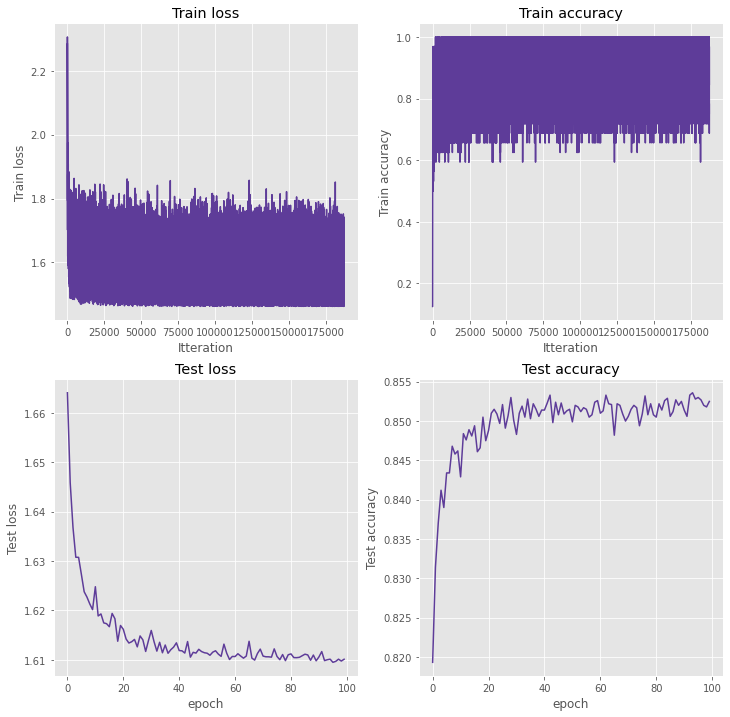

In [23]:
# Визуализация
history = (all_train_losses, all_train_accuracy, epoch_val_losses, epoch_val_accuracy)
loss_acc_plot(history)

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

**Несмещенная оценка на квадрат градиента:**

На каждой иттерации градиентный спуск Adam к квадрату градиента с одним весом добавляет квадрат градиента с другим весом, после чего они нормируются.
В итоге математическим ожиданием будет квадрат градиента, который не суммирован/помножен ни на какую константу, то есть несмещен. 

**Переобучение:** 

Переобучения нейронной сети не происходит

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [24]:
def train(model, dataloader, optimizer): # В целом train как в предыдущем пункте, но теперь есть возможность вносить разные модели

  all_train_losses = []
  all_train_accuracy = []
  epoch_val_losses = []
  epoch_val_accuracy = []
  loss = nn.CrossEntropyLoss()

  train_dataloader = dataloader[0]
  eval_dataloader = dataloader[1]

  for epoch in tqdm_notebook(range(1, 11)):
    for batch in train_dataloader:
        batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
        y_pred = model(batch[0])
        losses = loss(y_pred, batch[1]) 
        losses.backward() 
        optimizer.step() 
        optimizer.zero_grad() 

        pred_classes = (torch.argmax(y_pred, dim=-1) == batch[1]).cpu().numpy().tolist()
        all_train_losses.append(losses.item())
        all_train_accuracy.append(np.mean(pred_classes))


    mean_val_loss = [] 
    val_accuracy = []
    with torch.no_grad(): 
        for batch in eval_dataloader: 
            batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
            y_pred = model(batch[0]) 
            losses = loss(y_pred, batch[1]) 
            mean_val_loss.append(losses.cpu().numpy())  
            val_accuracy.extend((torch.argmax(y_pred, dim=-1) == batch[1]).cpu().numpy().tolist())
    
    epoch_val_losses.append(np.mean(mean_val_loss))
    epoch_val_accuracy.append(np.mean(val_accuracy))
  
  return all_train_losses, all_train_accuracy, epoch_val_losses, epoch_val_accuracy

In [25]:
class FirstModel(nn.Module): # Модель с полносвязными слоями
    def __init__(self):
        super(FirstModel, self).__init__()
        self.nn = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(28*28, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.nn(x)

model1 = FirstModel()
model1

FirstModel(
  (nn): Sequential(
    (0): Flatten()
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

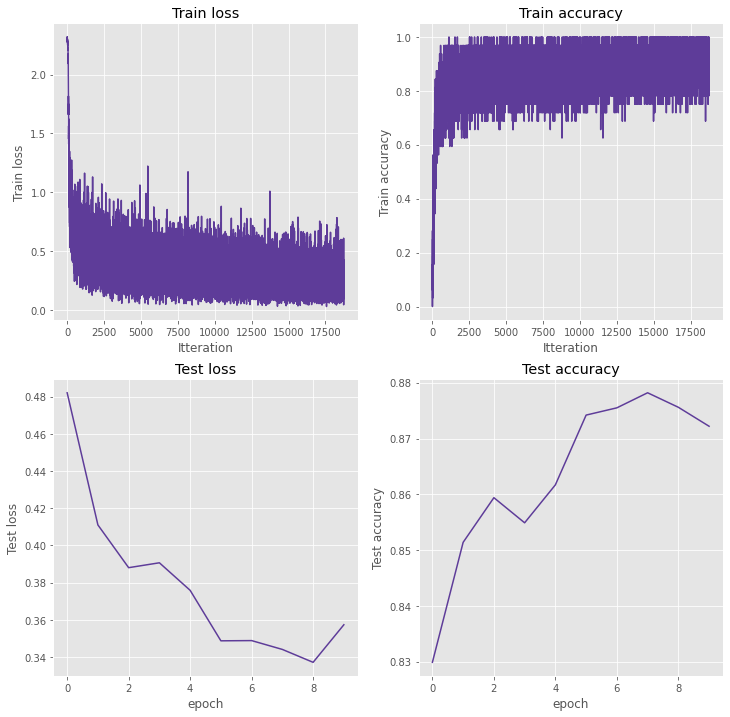

In [26]:
# Полносвязная нейронная сеть с SGD Momentum
torch.manual_seed(14) 
model1 = FirstModel().to(device)
history_model1_SGD = train(model1, (train_dataloader, eval_dataloader), torch.optim.SGD(model1.parameters(), lr=1e-2, momentum=0.9))
loss_acc_plot(history_model1_SGD)

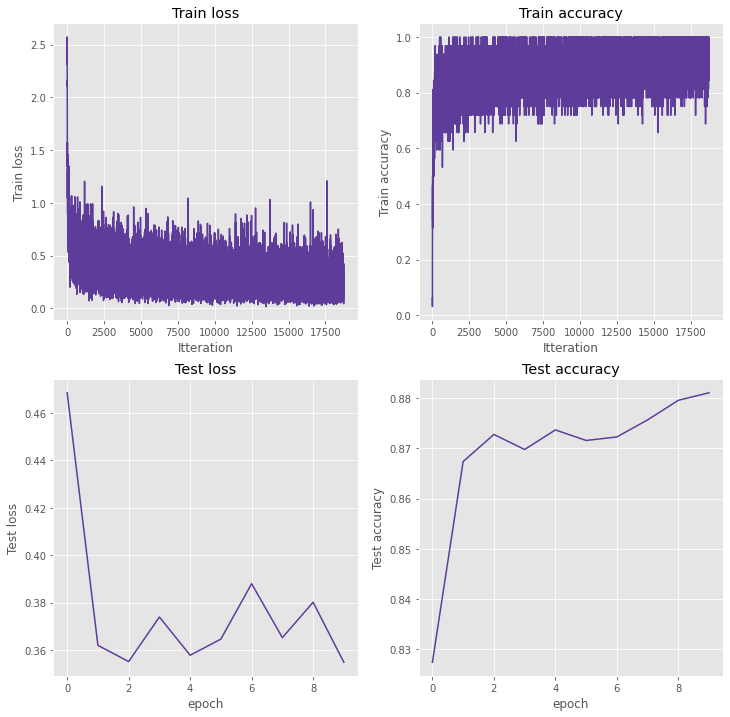

In [27]:
# Полносвязная нейронная сеть с RMSprop
torch.manual_seed(14) 
model11 = FirstModel().to(device)
history_model1_RMSprop = train(model11, (train_dataloader, eval_dataloader), torch.optim.RMSprop(model11.parameters(), lr=1e-3))
loss_acc_plot(history_model1_RMSprop)

In [28]:
class VGGblock(nn.Module): # VGG блок

    def __init__(self, in_chanels, out_chanels):
        super(VGGblock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_chanels, out_chanels, (3, 3), stride=(1, 1), padding=1), 
            nn.ReLU(),
            nn.Conv2d(out_chanels, out_chanels, (3, 3), stride=(1, 1), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 , stride = 2, padding=0)
            )
        
    def forward(self, x):   
        return self.net(x)

In [29]:
class SecondModel(nn.Module): # Свёрточная нейронная сеть

    def __init__(self):
        super(SecondModel, self).__init__()
        self.nn = nn.Sequential(
        VGGblock(1, 32),
        VGGblock(32, 64),
        nn.Flatten(),
        nn.Linear(64*7*7,128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.nn(x)

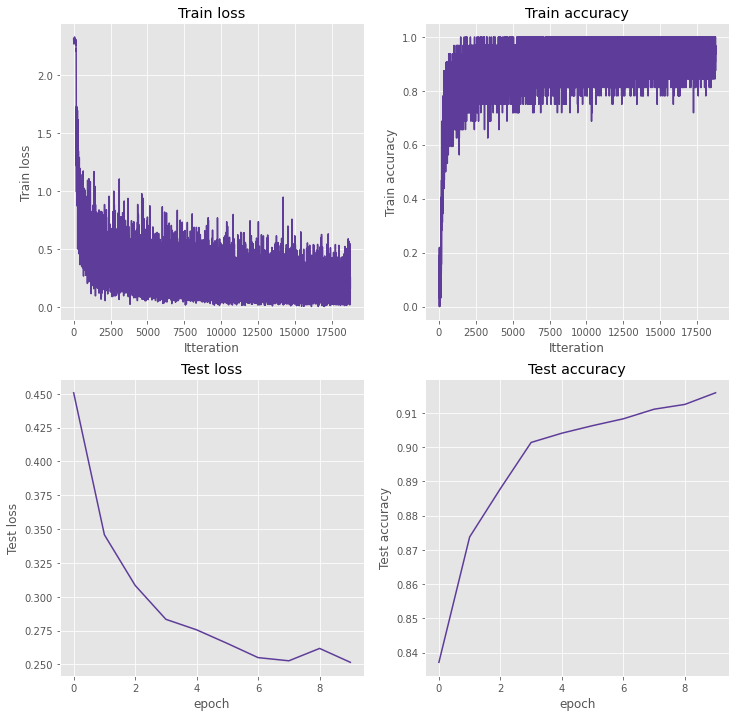

In [30]:
# Свеёрточная нейронная сеть VGG с SGD 
torch.manual_seed(14) 
model2 = SecondModel().to(device)
history_model2_SGD = train(model2, (train_dataloader, eval_dataloader), torch.optim.SGD(model2.parameters(), lr=1e-2, momentum=0.9))
loss_acc_plot(history_model2_SGD)

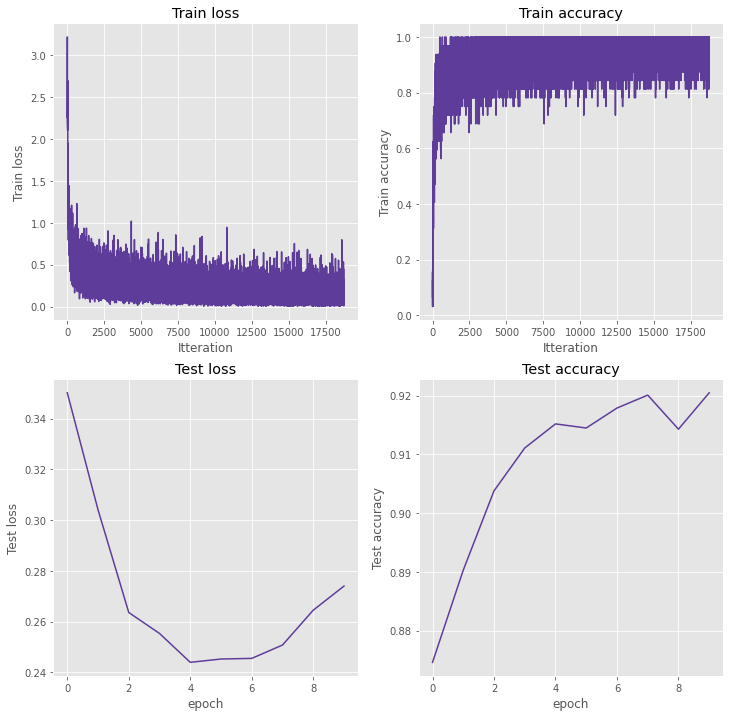

In [31]:
# Свёрточная нейронная сеть VGG с RMSprop
torch.manual_seed(14) 
model22 = SecondModel().to(device)
history_model2_RMSprop = train(model22, (train_dataloader, eval_dataloader), torch.optim.RMSprop(model22.parameters(), lr=1e-3))
loss_acc_plot(history_model2_RMSprop)

In [32]:
class ThirdModel(nn.Module): # Модель на основе Resnet

  def __init__(self, in_channels=1):
    super(ThirdModel, self).__init__()

    self.start = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=7, stride=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.conv1 = nn.Conv2d(64, 64, 3)
    self.conv2 = nn.Conv2d(64, 64, 3)
    self.conv3 = nn.Conv2d(64, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 64, 3)
    self.conv6 = nn.Conv2d(64, 128, 3)
    self.conv7 = nn.Conv2d(128, 128, 3)
  
    
    self.end = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1152, 1024),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Linear(1024, 128),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10))
    
  def forward(self, x):

    out = self.start(x)
    out = F.relu(self.conv3(F.relu(self.conv2(out)))) + out
    out = F.relu(self.conv5(F.relu(self.conv4(out)))) + out
    out = F.relu(self.conv6(out))
    return self.end(out)

model3 = ThirdModel()
print(model3)

ThirdModel(
  (start): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (end): Sequential(
    (0): Flatten()
    (1): Linear(in_features=1152, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.15, inplace=False)
    (4): Linear(in_features=1024, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.15, inplace=False)
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(i

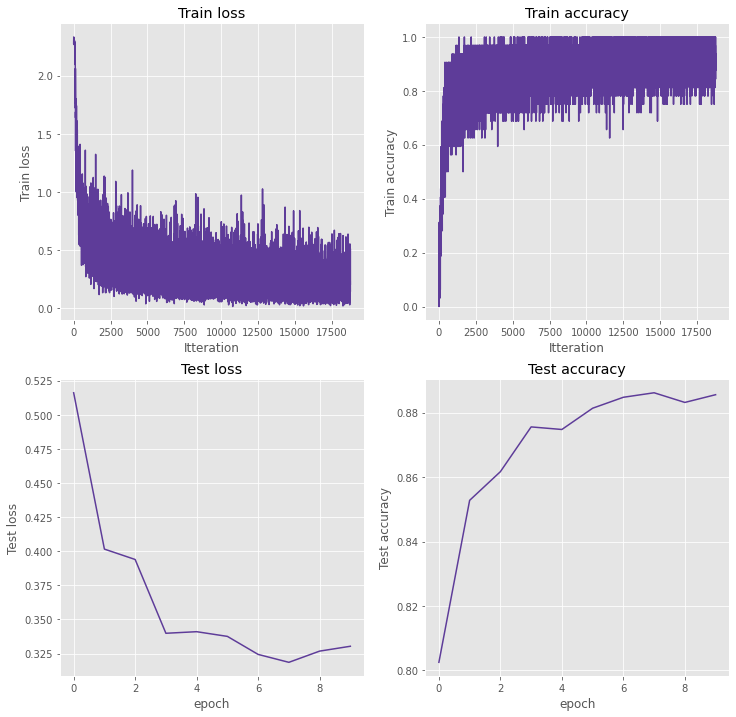

In [33]:
# Resnet с SGD 
torch.manual_seed(14)
model3_SGD = ThirdModel().to(device)
history_model3_SGD = train(model3_SGD, (train_dataloader, eval_dataloader), torch.optim.SGD(model3_SGD.parameters(), lr=1e-2, momentum=0.9))
loss_acc_plot(history_model3_SGD)

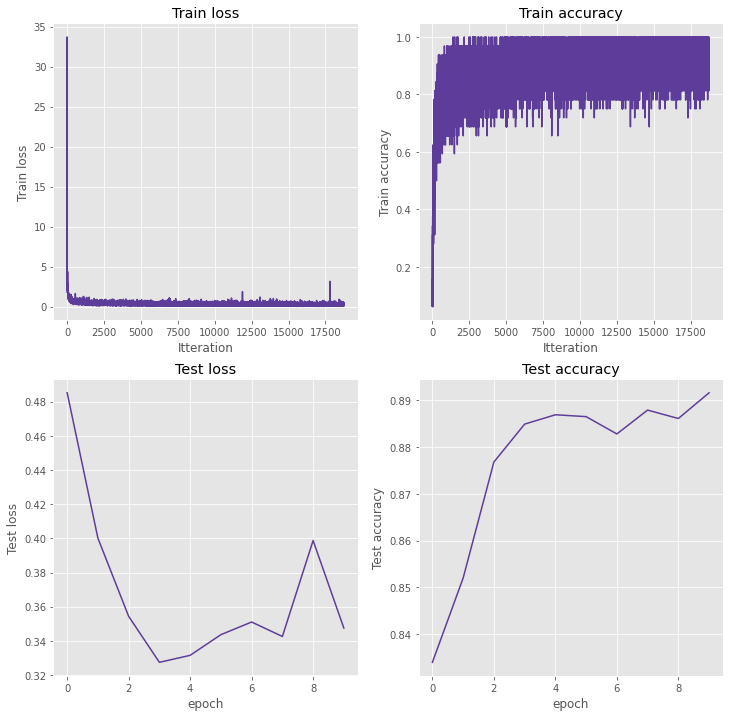

In [34]:
# Resnet с RMSprop 
torch.manual_seed(14)
model3_RMS = ThirdModel().to(device)
history_model3_RMSprop = train(model3_RMS , (train_dataloader, eval_dataloader), torch.optim.RMSprop(model3_RMS.parameters(), lr=1e-3))
loss_acc_plot(history_model3_RMSprop)

Общие выводы по каждой из моделей:

**1) Модель с полносвязными слоями**

Первой моделью была выбрана простенькая модель с 4 полносвязными слоями и нелинейностью между ними в виде функции активации ReLU, учитывая рекомендацию, что входы/выходы полносвязных слоёв - степени двойки. Стоит отметить, что несмотря на свою простоту (отсутствие современных сверхточных методов, макспулинга, а также методов против переобучения (dropout, batchnorm)) модель все равно показывает достаточно высокую долю правильных ответов на тесте: 87%.

**2) Модель со сверточными слоями**

Была выбрана архитектура на основе VGG блоков, один блок предполагает:

Conv2d

Relu

Conv2d

Relu

MaxPool2d 

То есть после каждого блока количество каналов увеличивается в 2 раза (степени двойки), а размер изображения уменьшается в два раза из-за макспулинга. В результате, более сложная модель со свертками позволяет достичь 91-92%. 

**3) Модель на основе Resnet**

Основную идею модели Residual Neural Network реализовать удалось:

Однако, модели не удалось показать качество выше сверточной нейронной сети с VGG блоками, возможно из-за её относительной простоты по сравнению с оригинальными крупными Resnet моделями; даже относительно простые, по типу Resnet18, имеют во много раз большее количество stacked layers. Качество около 90%.